## Shale Gas EUR Prediction
---

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.rcParams['figure.figsize'] = (15.0, 7.0)
sns.set_theme()

Data Set Source (Kaggle): https://www.kaggle.com/datasets/minhazengg/shale-wells-dataset?resource=download

In [17]:
shale_gas_raw = pd.read_csv('Shale_Gas_Wells_DataSet.csv')
shale_gas_raw.head()

Stage Spacing  bbl/ft  Well Spacing  Dip  Thickness  Lateral Length  \
0            140      38           850    0        165            8543   
1            140      30           900    0        174            8336   
2            140      30           900    0        174            9361   
3            140      30           950    0        175            9110   
4            140      30           950    0        175            9310   

   Injection Rate  Porosity  ISIP  Water Saturation  Percentage of LG  \
0              64       8.3  8200              17.1              38.0   
1              60       7.8  8061              16.0              59.3   
2              65       7.8  8061              16.0              59.3   
3              69       8.3  7922              15.7              66.9   
4              67       8.3  7922              15.7              66.9   

   Pressure Gradient  Proppant Loading   EUR    Category  
0               0.95              3012  13.3  New_Design  
1               0.95              2771  12.5  New_Design  
2               0.95              3067  16.9  New_Design  
3               0.95              3130  16.5  New_Design  
4               0.95              2991  17.4  New_Design

In [18]:
shale_gas_raw.shape

(506, 15)

---
__1. Data Spliting__

We will separate original data as training and testing in order to avoid data leakege during data pre-processing, feature engineering, and transformation. In this subject we are going to use 70-30 as training and testing respectively done by `StratifiedShuffleSplit` method.

In [19]:
from sklearn.model_selection import  StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in split.split(shale_gas_raw, shale_gas_raw.Category):
 strat_train_set = shale_gas_raw.loc[train_index]
 strat_test_set = shale_gas_raw.loc[test_index]

> 1.1. Missing Value Consistency Check

In [42]:
import numpy as np
y_binned = pd.qcut(y, q=5, labels=False)  # divide EUR into 5 bins
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X, y_binned):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


NameError: name 'y' is not defined

In [43]:
# Create feature matrix X and target y, then perform a stratified split on EUR quantiles
X = shale_gas_raw.drop('EUR', axis=1)
y = shale_gas_raw['EUR']

# Bin the target into 5 quantile-based groups for stratification
y_binned = pd.qcut(y, q=5, labels=False, duplicates='drop')

# Use the already imported StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X, y_binned):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Quick sanity check
print(f"X_train.shape: {X_train.shape}, X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}, y_test.shape: {y_test.shape}")

X_train.shape: (404, 14), X_test.shape: (102, 14)
y_train.shape: (404,), y_test.shape: (102,)


In [44]:
pickle.dump(model, open("trained_model.pkl", "wb"))
print("Model saved as trained_model.pkl")


Model saved as trained_model.pkl


In [47]:
import os
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Ensure y_test and y_train exist
if 'y_test' not in globals() or 'y_train' not in globals():
    raise RuntimeError("y_train or y_test is not defined in the notebook.")

# Prepare y_pred: use existing y_pred if present, else try saved model, else fallback to median baseline
if 'y_pred' in globals():
    print("Using existing y_pred.")
else:
    y_pred = None
    model_file = "trained_model.pkl"
    if os.path.exists(model_file):
        try:
            with open(model_file, "rb") as f:
                model = pickle.load(f)
            # Prepare feature matrix for prediction
            X_for_pred = X_test.copy() if 'X_test' in globals() else None
            if X_for_pred is None:
                raise RuntimeError("X_test not found for model prediction.")
            if 'EUR' in X_for_pred.columns:
                X_for_pred = X_for_pred.drop('EUR', axis=1)
            # Try numeric-only features as a safe fallback
            X_num = X_for_pred.select_dtypes(include=[np.number])
            if X_num.shape[1] == 0:
                raise RuntimeError("No numeric features available in X_test to feed the model.")
            y_pred = pd.Series(model.predict(X_num), index=y_test.index)
            print("Predictions generated using trained_model.pkl")
        except Exception as e:
            print(f"Could not use saved model ({e}). Falling back to median baseline.")
    if y_pred is None:
        # Median baseline predictor
        median_val = y_train.median()
        y_pred = pd.Series(median_val, index=y_test.index)
        print(f"Using median baseline predictor (median EUR = {median_val}).")

# Compute metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² (accuracy): {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Could not use saved model ('NoneType' object has no attribute 'predict'). Falling back to median baseline.
Using median baseline predictor (median EUR = 12.45).
R² (accuracy): -0.0181
Mean Absolute Error (MAE): 2.0873
Root Mean Squared Error (RMSE): 2.9790


In [4]:
# Robust Actual vs Predicted scatter plot (fixed & recoverable)
# Requires: pd, np, plt (already imported in earlier cells)

# Try to recover y_test
if 'y_test' not in globals():
    if 'strat_test_set' in globals() and 'EUR' in strat_test_set.columns:
        y_test = strat_test_set['EUR']
        print("Recovered y_test from strat_test_set['EUR'].")
    else:
        raise RuntimeError("y_test is not defined. Run the split cell (or ensure strat_test_set with 'EUR' exists).")

# Try to recover or compute y_pred
if 'y_pred' not in globals():
    y_pred = None
    model_file = "trained_model.pkl"
    # Try loading a saved model
    if os.path.exists(model_file):
        try:
            with open(model_file, "rb") as f:
                model = pickle.load(f)
            # get X_test if available
            if 'X_test' in globals():
                X_for_pred = X_test.copy()
            elif 'strat_test_set' in globals():
                X_for_pred = strat_test_set.copy()
            else:
                X_for_pred = None

            if X_for_pred is None:
                raise RuntimeError("X_test or strat_test_set not found for model prediction.")

            if 'EUR' in X_for_pred.columns:
                X_for_pred = X_for_pred.drop('EUR', axis=1)

            X_num = X_for_pred.select_dtypes(include=[np.number])
            if X_num.shape[1] == 0:
                raise RuntimeError("No numeric features available in test set to feed the model.")
            y_pred = pd.Series(model.predict(X_num), index=y_test.index)
            print("Predictions generated using trained_model.pkl")
        except Exception as e:
            print(f"Could not use saved model ({e}). Falling back to median baseline.")
    # Median baseline fallback
    if y_pred is None:
        if 'y_train' in globals():
            median_val = y_train.median()
        elif 'strat_train_set' in globals() and 'EUR' in strat_train_set.columns:
            median_val = strat_train_set['EUR'].median()
        else:
            raise RuntimeError("y_pred not available and no y_train/strat_train_set to compute baseline.")
        y_pred = pd.Series(median_val, index=y_test.index)
        print(f"Using median baseline predictor (median EUR = {median_val}).")
else:
    print("Using existing y_pred.")

# Ensure Series and align
y_test_s = y_test if isinstance(y_test, pd.Series) else pd.Series(y_test, index=getattr(y_test, 'index', None))
y_pred_s = y_pred if isinstance(y_pred, pd.Series) else pd.Series(y_pred, index=getattr(y_pred, 'index', None))

# Align indices if possible
common_idx = y_test_s.index.intersection(y_pred_s.index) if (hasattr(y_test_s, 'index') and hasattr(y_pred_s, 'index')) else None
if common_idx is not None and len(common_idx) > 0:
    y_test_vals = y_test_s.loc[common_idx].values
    y_pred_vals = y_pred_s.loc[common_idx].values
else:
    y_test_vals = y_test_s.values
    y_pred_vals = y_pred_s.values

if len(y_test_vals) != len(y_pred_vals):
    raise RuntimeError(f"After alignment y_test and y_pred lengths differ: {len(y_test_vals)} vs {len(y_pred_vals)}")

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_vals, y_pred_vals, color='tab:blue', alpha=0.6, s=40, edgecolors='k', marker='o')
min_val = float(min(np.nanmin(y_test_vals), np.nanmin(y_pred_vals)))
max_val = float(max(np.nanmax(y_test_vals), np.nanmax(y_pred_vals)))
# add a small padding
pad = (max_val - min_val) * 0.02 if max_val > min_val else 1.0
plt.plot([min_val - pad, max_val + pad], [min_val - pad, max_val + pad], 'r--', linewidth=1)  # perfect prediction line
plt.xlabel("Actual EUR (Bscf)")
plt.ylabel("Predicted EUR (Bscf)")
plt.title("Actual vs Predicted EUR")
plt.grid(True)
plt.xlim(min_val - pad, max_val + pad)
plt.ylim(min_val - pad, max_val + pad)
plt.tight_layout()
plt.show()


RuntimeError: y_test is not defined. Run the split cell (or ensure strat_test_set with 'EUR' exists).

In [7]:
import os
import pandas as pd
import os
import pickle

model_file = "trained_model.pkl"
if not os.path.exists(model_file):
    raise FileNotFoundError(f"{model_file} not found. Train and save a model first.")

with open(model_file, "rb") as f:
    model = pickle.load(f)

# Example: predict EUR for a new well (provide feature names/values you expect)
new_well = pd.DataFrame([{
    'Lateral_Length': 2500,
    'Proppant_Amount': 2000,
    'Fluid_Volume': 10000,
    'Well_Depth': 3000,
    'Cluster_Count': 10
}])

# If the model exposes expected feature names, align the input to that order and fill missing cols with 0
if hasattr(model, "feature_names_in_"):
    expected = list(model.feature_names_in_)
    new_well = new_well.reindex(columns=expected, fill_value=0)

predicted_eur = model.predict(new_well)
print("Predicted EUR (Bscf):", float(predicted_eur[0]))


AttributeError: 'NoneType' object has no attribute 'predict'

In [10]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pickle

# Load dataset
data = pd.read_csv("Shale_Gas_Wells_DataSet.csv")  # replace with your CSV
features = ['Lateral_Length', 'Proppant_Amount', 'Fluid_Volume', 'Well_Depth', 'Cluster_Count']
X = data[features]
y = data['EUR']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save the trained model
with open("trained_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("Model trained and saved successfully.")


KeyError: "None of [Index(['Lateral_Length', 'Proppant_Amount', 'Fluid_Volume', 'Well_Depth',\n       'Cluster_Count'],\n      dtype='object')] are in the [columns]"

After spliting we concern about data integration, for instance about missing data in which showing inconsistency between training & spliting. In order to check it, we a chunk of code below

_On Training Data Set_

In [ ]:
total = strat_train_set.isnull().sum().sort_values(ascending=False)
percent = (strat_train_set.isnull().sum()/strat_train_set.isnull().count()).sort_values(ascending=False)*100
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

Total  Percent
Stage Spacing          0      0.0
bbl/ft                 0      0.0
Well Spacing           0      0.0
Dip                    0      0.0
Thickness              0      0.0
Lateral Length         0      0.0
Injection Rate         0      0.0
Porosity               0      0.0
ISIP                   0      0.0
Water Saturation       0      0.0
Percentage of LG       0      0.0
Pressure Gradient      0      0.0
Proppant Loading       0      0.0
EUR                    0      0.0
Category               0      0.0

_On Testing Data Set_

In [ ]:
total = strat_test_set.isnull().sum().sort_values(ascending=False)
percent = (strat_test_set.isnull().sum()/strat_test_set.isnull().count()).sort_values(ascending=False)*100
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

Total  Percent
Stage Spacing          0      0.0
bbl/ft                 0      0.0
Well Spacing           0      0.0
Dip                    0      0.0
Thickness              0      0.0
Lateral Length         0      0.0
Injection Rate         0      0.0
Porosity               0      0.0
ISIP                   0      0.0
Water Saturation       0      0.0
Percentage of LG       0      0.0
Pressure Gradient      0      0.0
Proppant Loading       0      0.0
EUR                    0      0.0
Category               0      0.0

Apparently, we safe to conduct further step since there is no inconsistency in missing value, Moreover, in fact, we don't have any missing value between those data set.

> 1.2. Data Drifting Evaluation

On this chapter we are going to conduct drifting analysis to check whether our data after splitting still have similar data distribution between training & testing

In [ ]:
from collections import Counter

def drifting_histograms(df, dfs, variables, n_rows, n_cols):
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        try:
            df[var_name].hist(bins=40,ax=ax,color = 'green',alpha=0.5, figsize = (15, 24), density=True)
            dfs[var_name].hist(bins=40,ax=ax,color = 'r',alpha=0.5, figsize = (15, 24), density=True)
        except:
            cnt = Counter(df[var_name])
            cnts = Counter(dfs[var_name])
            cnt.hist(bins=40,ax=ax,color = 'green',alpha=0.5, figsize = (15, 24), density=True)
            cnts.hist(bins=40,ax=ax,color = 'r',alpha=0.5, figsize = (15, 24), density=True)

        ax.set_title(var_name, fontsize = 10)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 8)
        ax.tick_params(axis = 'both', which = 'minor', labelsize = 8)
        ax.set_xlabel('')
    fig.tight_layout(rect = [0, 0.03, 1, 0.95])  # Improves appearance a bit.
    plt.show()

In [ ]:
variables = strat_train_set.columns
variables

Index(['Stage Spacing', 'bbl/ft', 'Well Spacing', 'Dip', 'Thickness',
       'Lateral Length', 'Injection Rate', 'Porosity', 'ISIP',
       'Water Saturation', 'Percentage of LG', 'Pressure Gradient',
       'Proppant Loading', 'EUR', 'Category'],
      dtype='object')

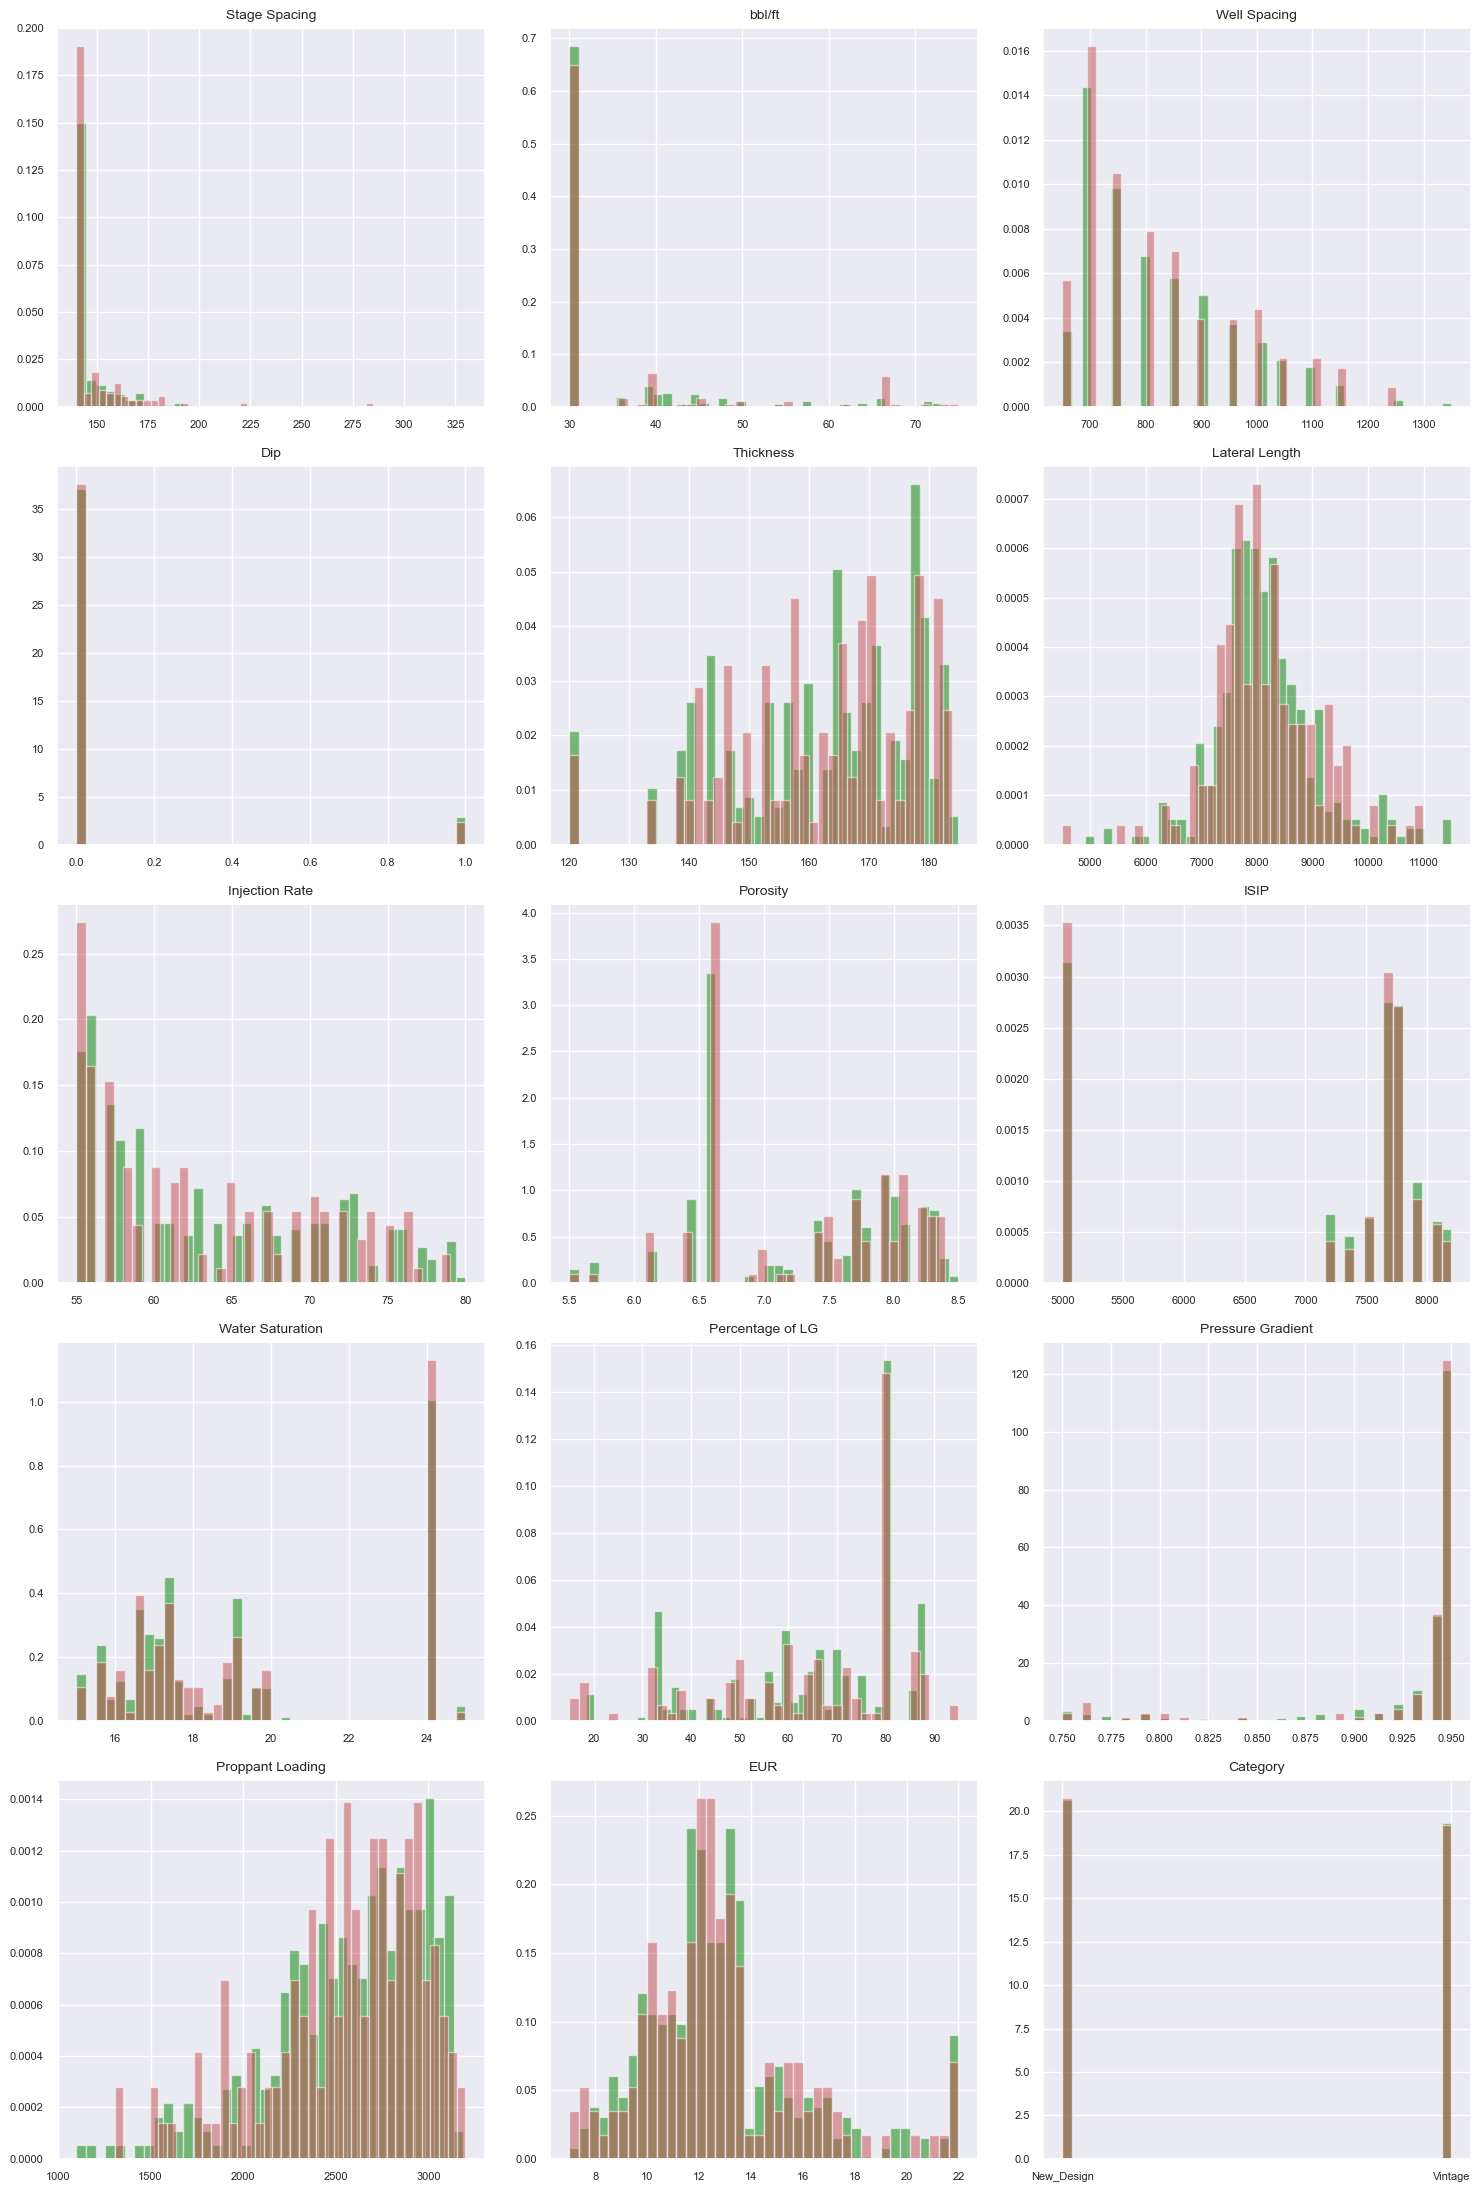

In [ ]:
drifting_histograms(strat_train_set, strat_test_set, variables, 5, 3)

From plots above, We can imply that both training & testing set have similar data distribution and this could be a good indication that we don't experience any data drifting problems. This assumption is important in machine learning.

---
__2. Exploratory Data Analysis (EDA)__

In [ ]:
strat_train_set.head()

Stage Spacing  bbl/ft  Well Spacing  Dip  Thickness  Lateral Length  \
274            140      48           850    1        177            8788   
60             140      41          1050    0        176            7424   
293            140      30           950    0        178            7942   
486            152      30           800    0        159            7924   
160            143      30           700    1        156            8107   

     Injection Rate  Porosity  ISIP  Water Saturation  Percentage of LG  \
274              72       7.8  7783              16.3              57.6   
60               64       8.0  7226              16.9              75.4   
293              76       7.0  7783              16.9              43.9   
486              60       6.6  5000              24.1              79.7   
160              57       6.4  7643              19.1              32.9   

     Pressure Gradient  Proppant Loading   EUR    Category  
274               0.95              3096  16.1  New_Design  
60                0.95              2538  11.6     Vintage  
293               0.95              2803  13.3     Vintage  
486               0.95              2432  11.7     Vintage  
160               0.92              2982  14.3  New_Design

> 2.1. General Information

In [ ]:
strat_train_set.describe().T

count         mean          std      min       25%  \
Stage Spacing      354.0   147.618644    19.040699   140.00   140.000   
bbl/ft             354.0    34.824859     9.957294    30.00    30.000   
Well Spacing       354.0   819.632768   133.179172   650.00   700.000   
Dip                354.0     0.073446     0.261237     0.00     0.000   
Thickness          354.0   162.460452    15.652019   120.00   153.000   
Lateral Length     354.0  8153.296610   937.238028  4905.00  7632.500   
Injection Rate     354.0    63.197740     7.314497    55.00    57.000   
Porosity           354.0     7.330508     0.751147     5.50     6.600   
ISIP               354.0  7035.053672  1198.247256  5000.00  5556.500   
Water Saturation   354.0    19.139266     3.191501    15.00    16.800   
Percentage of LG   354.0    65.089548    17.857796    18.40    55.900   
Pressure Gradient  354.0     0.930678     0.045126     0.75     0.940   
Proppant Loading   354.0  2574.429379   416.518345  1100.00  2312.250   
EUR                354.0    12.880791     3.080446     7.00    11.025   

                       50%      75%       max  
Stage Spacing       141.00   147.00    330.00  
bbl/ft               30.00    36.00     73.00  
Well Spacing        800.00   900.00   1350.00  
Dip                   0.00     0.00      1.00  
Thickness           165.00   177.00    185.00  
Lateral Length     8053.00  8593.75  11500.00  
Injection Rate       61.00    69.00     80.00  
Porosity              7.50     8.00      8.50  
ISIP               7643.00  7783.00   8200.00  
Water Saturation     17.70    24.10     25.00  
Percentage of LG     69.90    79.70     88.20  
Pressure Gradient     0.95     0.95      0.95  
Proppant Loading   2656.50  2910.75   3189.00  
EUR                  12.45    13.70     22.00

Statistics summary from table above implies that our training dataset have reasonable entries representing by not having data magnitude that is categorized as anomaly in petroleum engineering knowledge. Moreover, clearly these entries resemble somewhat realistic imputation by not having others human/ system generated mistake.

In [ ]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354 entries, 274 to 277
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Stage Spacing      354 non-null    int64  
 1   bbl/ft             354 non-null    int64  
 2   Well Spacing       354 non-null    int64  
 3   Dip                354 non-null    int64  
 4   Thickness          354 non-null    int64  
 5   Lateral Length     354 non-null    int64  
 6   Injection Rate     354 non-null    int64  
 7   Porosity           354 non-null    float64
 8   ISIP               354 non-null    int64  
 9   Water Saturation   354 non-null    float64
 10  Percentage of LG   354 non-null    float64
 11  Pressure Gradient  354 non-null    float64
 12  Proppant Loading   354 non-null    int64  
 13  EUR                354 non-null    float64
 14  Category           354 non-null    object 
dtypes: float64(5), int64(9), object(1)
memory usage: 44.2+ KB


According to the table above, our training dataset has 15 features and 1 target (EUR). Every feature doesn't have null value and various data type where majority (9 features) might be presented as `int64`. 6 features are `float64` and just only 1 is categorized as `object`.

> 2.2. Wrong Entries Checking

In [ ]:
def object_wrong_entries_checking(train, test):
    col_ = train.columns

    print('## Entries in Training Data Set:')
    for i in col_:
        if train[i].dtype == object:
            print('{}: {}'.format(i, train[i].unique()))

        else:
            continue

    print('---------------------------------------------------------------')

    print('## Entries in Test Data Set:')
    for i in col_:
        if test[i].dtype == object:
            print('{}: {}'.format(i, test[i].unique()))

        else:
            continue

In [ ]:
object_wrong_entries_checking(strat_train_set, strat_test_set)

## Entries in Training Data Set:
Category: ['New_Design' 'Vintage']
---------------------------------------------------------------
## Entries in Test Data Set:
Category: ['Vintage' 'New_Design']


Many mistake could exist in dataset for instance a feature containing a wrong symbol such as '-, %, #, &' and many more. By using our function `object_wrong_entries_checking` we believe that this mistake could be identified simply by looking to data that has data type as 'object'. We don't test on integer or float data type since it is simply not possible that wrong symbol exists. Having these mistake identified, we could clean it up in data cleaning process but for this project, we are blessed that we don't have any mistake in data entries both for training & test dataset.

NOTE: Although we are not able to look at the future meaning that we are not allowed to see testing dataset but this processes aim to inform us in advance that special data handling/ pipeline is needed on this feature to overcome data mistake if it's showing some wrong entries on each/ both dataset.

> 2.3. Inconsistent Entries Checking

In [ ]:
def object_inconsistent_entries(train, test):
    col_ = train.columns

    for i in col_:
        if train[i].dtype == object:
            print('{}, {}'.format(i, set(test[i]).difference(set(train[i])))) #Does a feature in test data has different item than training?

        else:
            continue

In [ ]:
object_inconsistent_entries(strat_train_set, strat_test_set) #Does a feature in test data has different item than training? If YES, the answere is revealed as result

Category, set()


By using `object_inconsistent_entries` function we are looking for inconsistent entries in train & test dataset. We belive this risk only occurs in 'object' data type but not in other type. If we separate a dataset to become train & test but some of the entries in test dataset that we are intended to be isolated from train dataset have unique value but not exist in train dataset so our model could be in trouble since we are not prepared in data preparation and modeling.

Luckily, for this project we don't have any anomalies in train & test dataset. So it is safe to say that object type feature are consistent.

NOTE: Although we are not able to look at the future meaning that we are not allowed to see testing dataset but this processes aim to inform us in advance that special data handling/ pipeline is needed on this particular feature to overcome data inconsistencies if it occures on each/ both dataset.

> 2.4. Feature Explanation

for each features

> 2.5. Data Characteristics

In [ ]:
from collections import Counter
from statsmodels.graphics.gofplots import qqplot

def data_char(dataset):
    var_ = dataset.columns

    fig=plt.figure(figsize=(20, 50))
    for i, var_name in enumerate(var_):
        ax=fig.add_subplot(var_.shape[0], 3, (i*3)+1)
        bx=fig.add_subplot(var_.shape[0], 3, (i*3)+2)
        cx=fig.add_subplot(var_.shape[0], 3, (i*3)+3)
        try:
            sns.histplot(x=var_name, data=dataset, stat='probability', ax=ax, color='skyblue')
            sns.boxplot(x=var_name, data=dataset, ax=bx, color='salmon')
            qqplot(strat_train_set[var_name], fit=True, line='s', ax=cx, markerfacecolor='c', markeredgecolor='c', alpha=0.3)

        except:
            break

    fig.tight_layout(rect = [0, 0.03, 1, 0.95])  # Improves appearance a bit.
    plt.show();

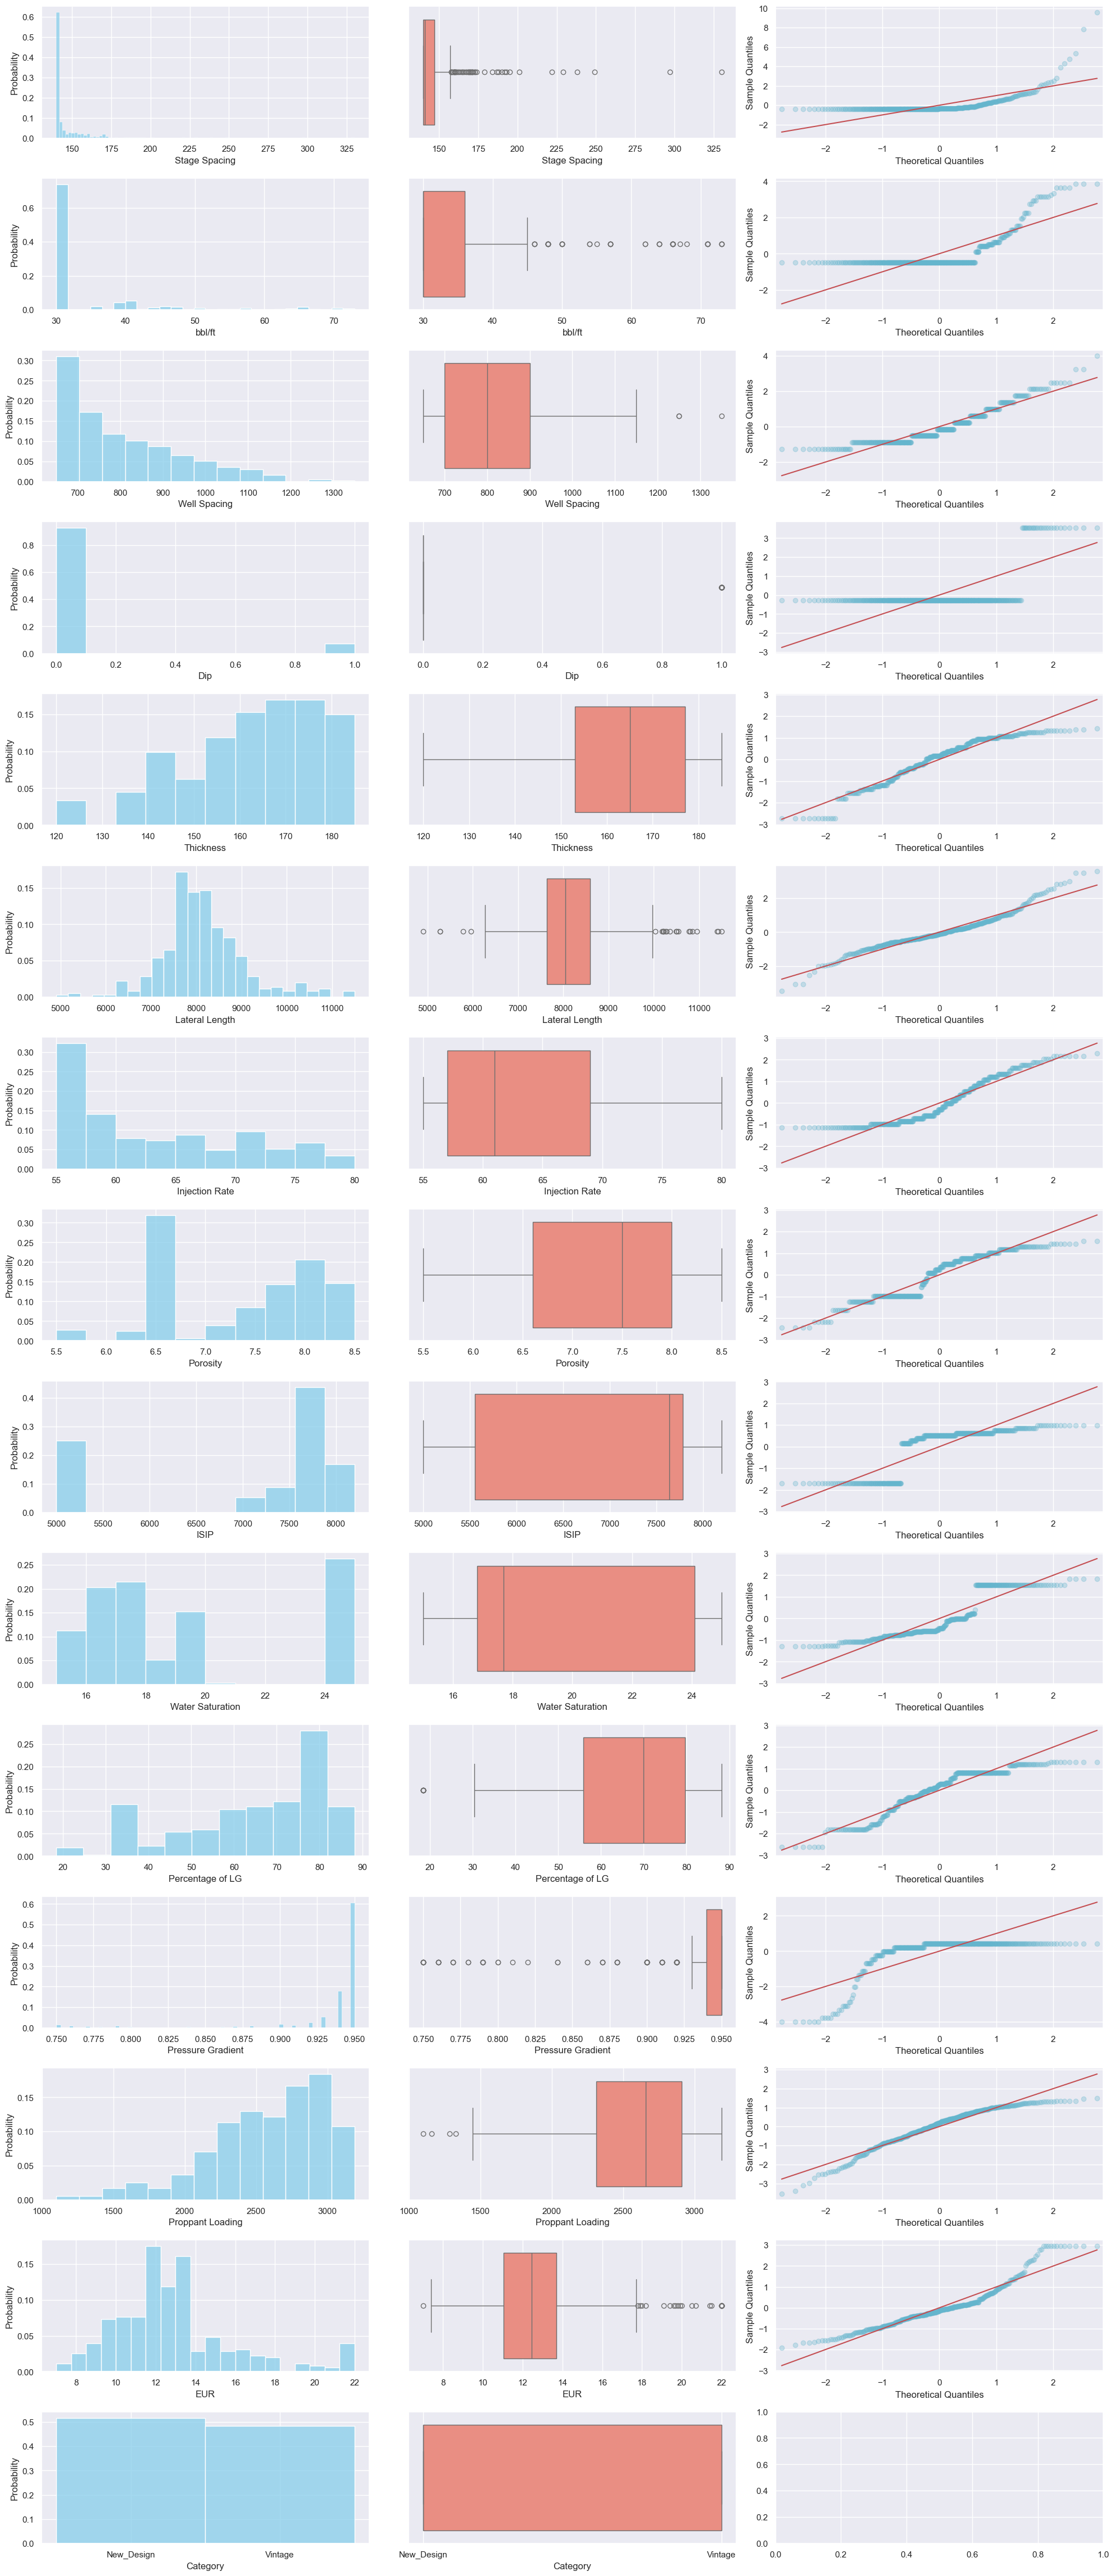

In [ ]:
data_char(strat_train_set)

On boxplot above, we notice that many outliers occur in our dataset. Not only these value are real and posibly exist in reality but also subtantialy consistent with our understanding of oil & gas data. So we decide to conduct further analysis in outliers data and act accordingly had the outliers are anomalies.

Based on our analysis by using visual evaluation on Q-Q Plots, we conclude that from all features only 2 features that somewhat resemble normal distribution. These feature are `EUR` and `Lateral Lenght`. Others data deviate from normal distribution by various magnitudes and characteristics. In order to comply with parametric ML algorithms assumption such as linear regression when Non normal distribution could effect the quality our model, therefore we are going to transform these data distribution by using transformation method such as Power in data cleaning section.

> 2.6. Outliers Investigation

_Relation to Target Variable & Other Independent Variables_

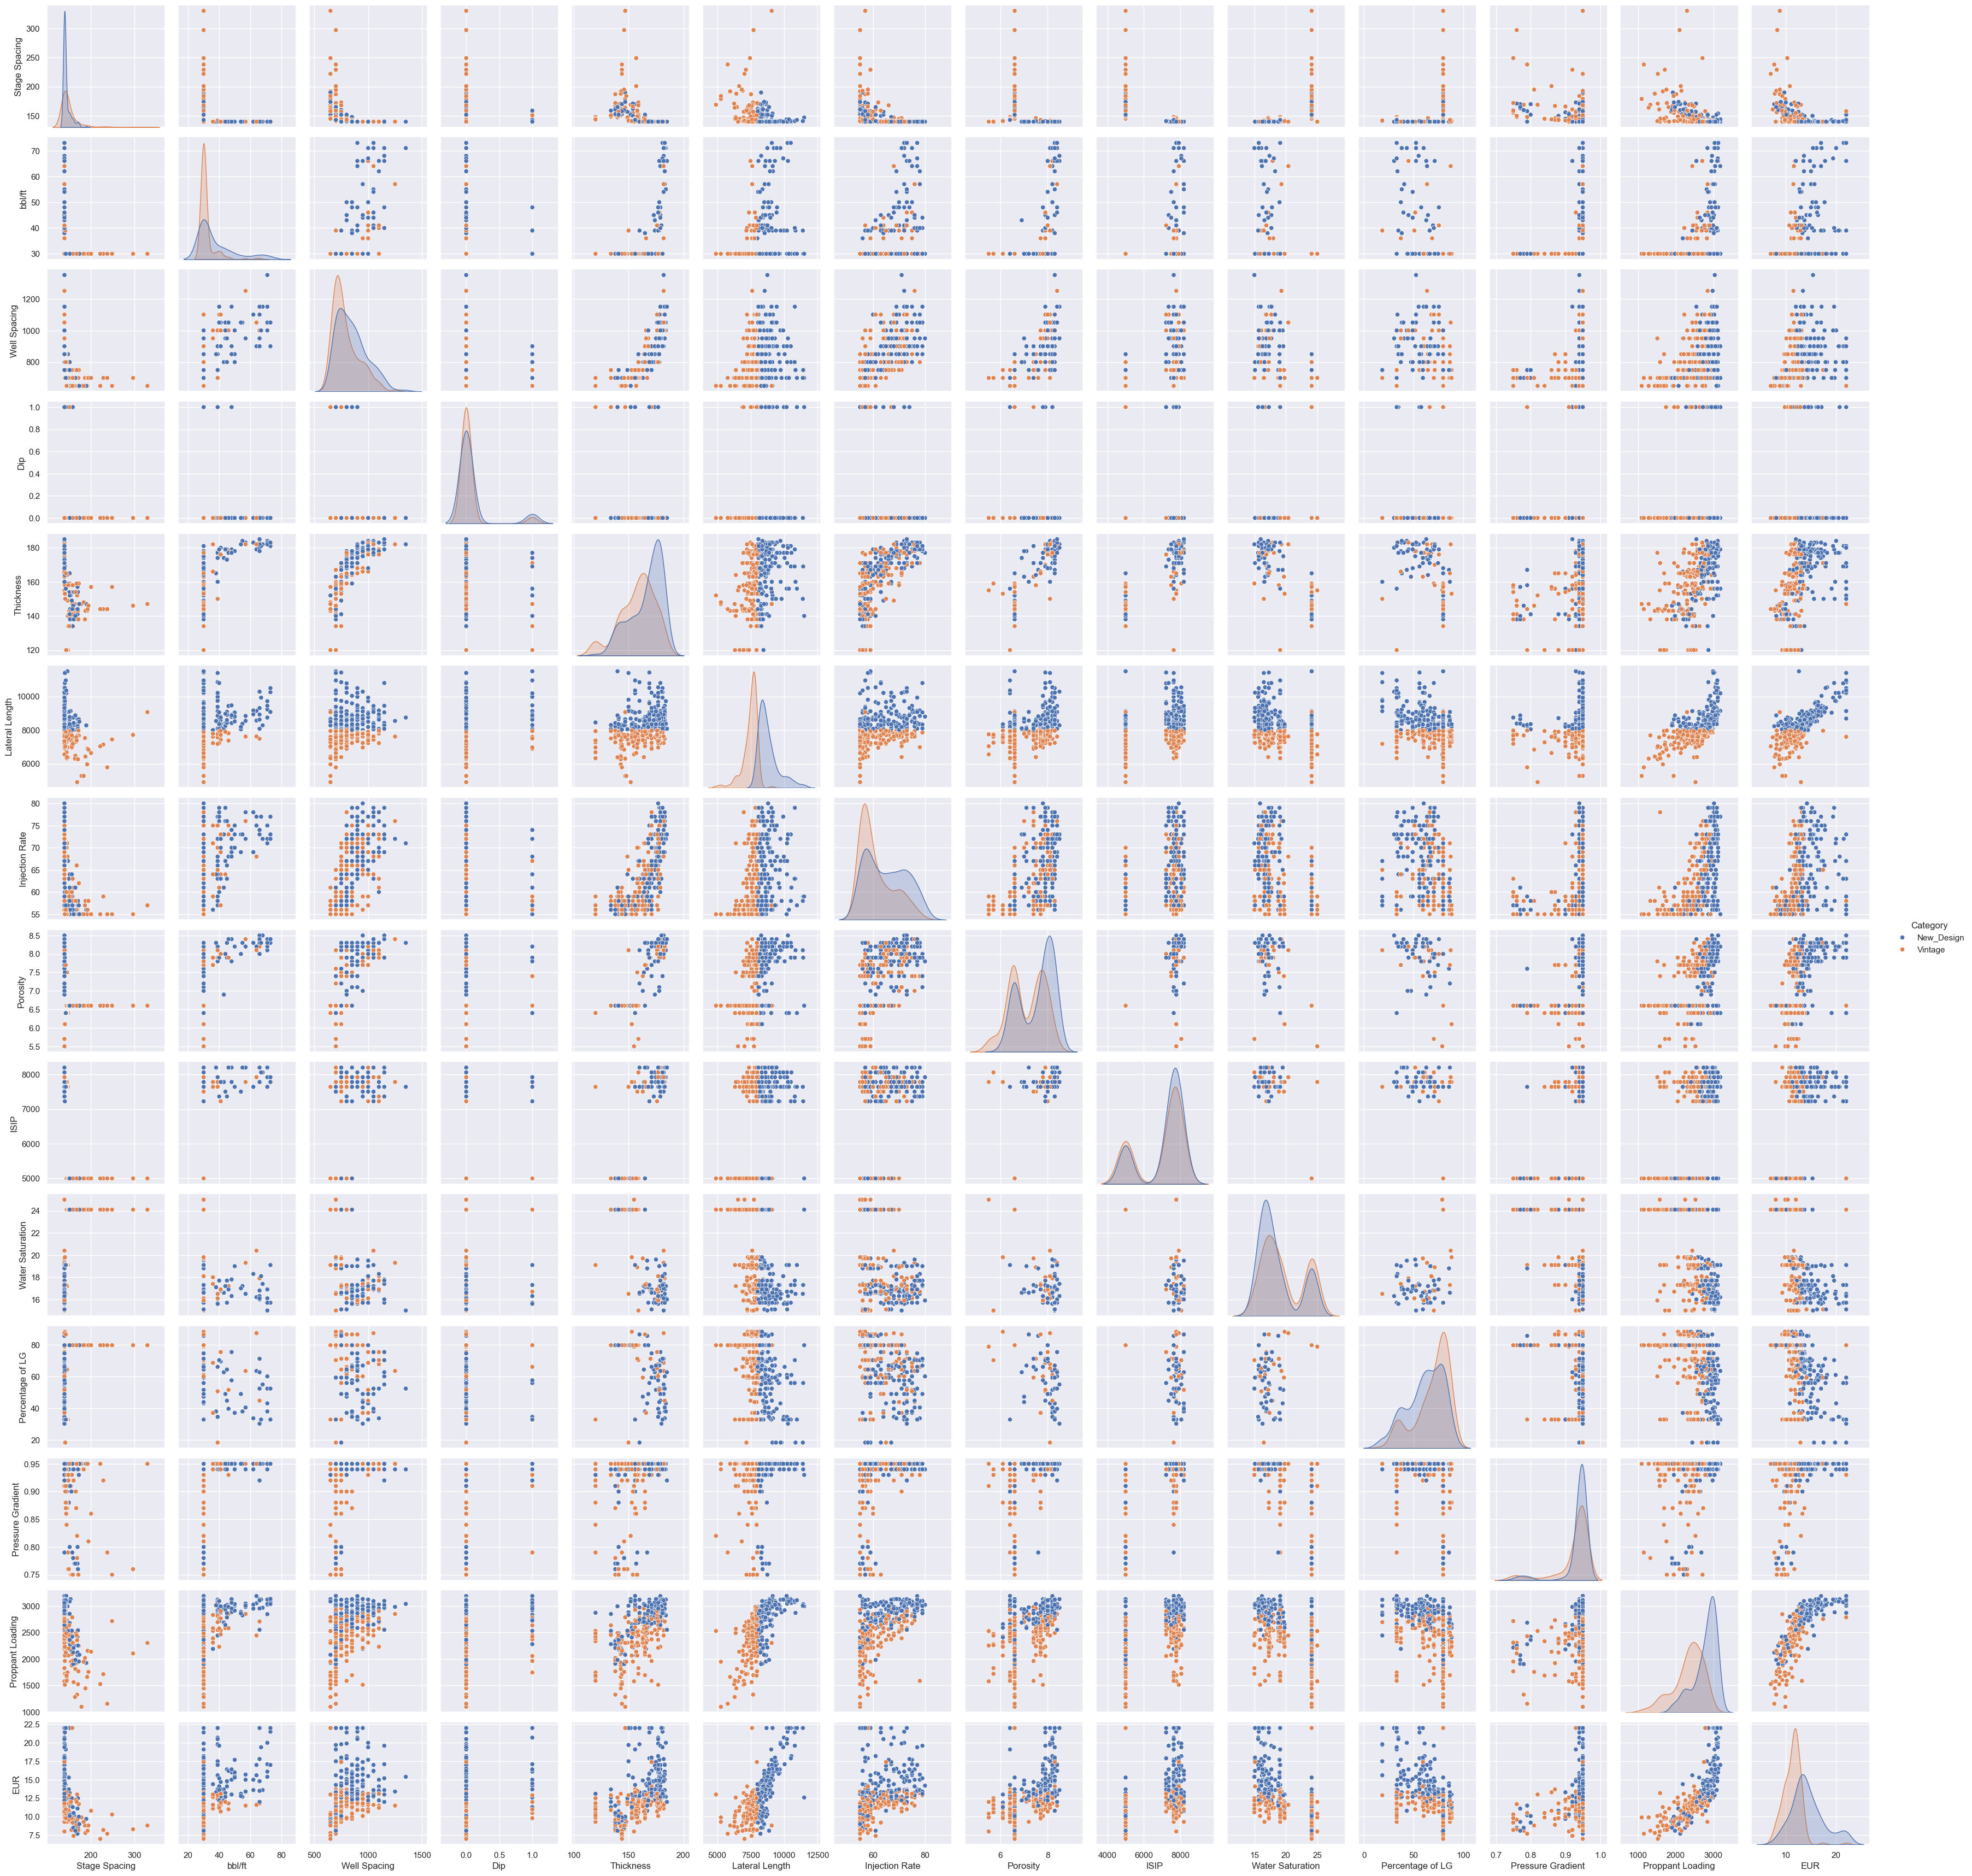

In [ ]:
sns.pairplot(strat_train_set, hue='Category');

Based on outliers analysis by using pair plot & box plot. We are able to imply that outliers will be retained in our dataset since they indicate some meaningful representation/ relation to target variable justified by "High Leverage Value (X)" analysis. Although none of those outliers from each variable are justified to be dropped (refer to: handnote regarding outliers handling), but still we will conduct 2 separate analysis to measure outliers impact in our model. First model will be run with outliers and other will not.

> 2.7. Data Correlation Study

As mentioned in outliers analysis that all outliers are meaningful and possibly having real relation to target variable but more deeper analysis are also needed to justify correlation values between 2 independents variable since they are prone to be biased because of outliers caused by "High Leverage Observation (X)". This insight will be useful for engineer to gain rigorous understanding of fraturing mechanism involving shale formation in gas field.

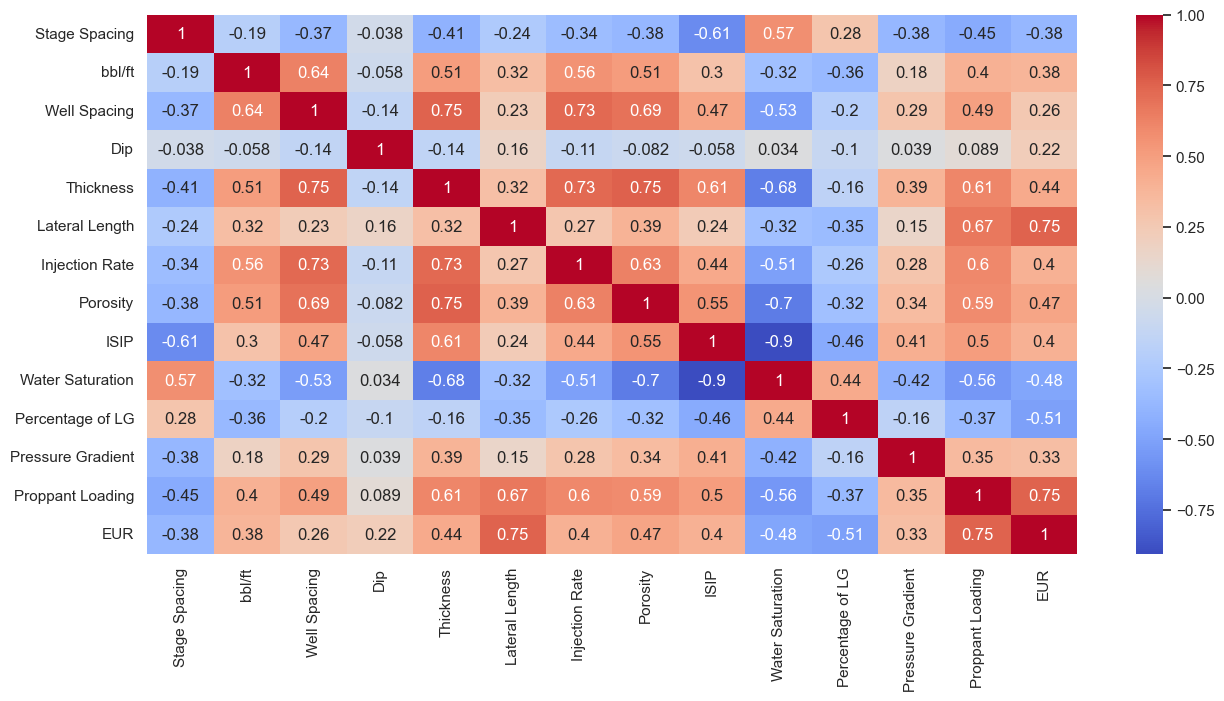

In [ ]:
train_corr = strat_train_set._get_numeric_data().corr()

sns.heatmap(train_corr, annot=True, cmap='coolwarm');

By observing correlation values between each feature and target (EUR), one could infer that some features are correlate well to EUR by certain degree (> 0.5) but most of them are not. Features such as `Lateral Length` and `Proppant Loading` have strong positive correlation to EUR but `Percentage of LG` has opposite magnitude.

Heatmap plot has been used as effective tool to gain general understanding about underlying mechanism. In this study we could integrate our knowledge in Oil & Gas industry with meaningful information that could be obtained on dataset. Assuming the dataset that we collect are in good quality and validated by "High Leverage Observation"/ "HLO" analysis, it is no doubt that the information we gather from heatmap will confirm our scientific knowledge.

Some evidents that we found are:
- Thicker reservoir will need more `Proppant Loading` and thus probably higher `Injection Rate` to accomodate this operation if time is our primary concern. By using longer `Lateral Length` also lead to more `Proppant Loading` requirement despite some "High Leverage Obsv" occurs on `Lateral Length` (refer to `Lateral Length` boxplot) but this relationship is valid. Some insight (but relatively low correlation showing in the heatmap and influence of outliers of `Proppant Loading` as HLO in pairplot) come up when we look to `Proppant Loading` vs `Water Saturation` relationship in which implicit information telling us that we need to reduce `Proppant Loading` when the net pay is not preferable (higher `Water Saturation`)
- By having bigger net pay reservoir (representing as bigger `Porosity`, thicker reservoir/ `Thickness`, and lower `Water Saturation`), we are able to reduce the number of well (higher `Well Spacing`) with slightly bigger wellbore (`bbl/ft`) configuration and these correlation values are valid and free from HLO
- `Dip`, has no meaningful impact on other variables
- Speaking about petrophysical aspect by using `Porosity`, `Water Saturation`, and `Thickness`. One could draw logical relationship that thin reservoirs tend to have higher `Water Saturation` since it is governed by transition effect but on the other hand, higher `Porosity` could reduce this transition effect because of less turtuosity then resulting in lower `Water Saturation` and these correlation values are valid and free from HLO but outliers exists on Y
- When looking to heatmap we notice that `ISIP` relationship to `Water Saturation` is significant but when we observe in pairplot this relationship is biased. Therefore, high correlation value is suspected due to outliers outside data population since they shift the correlation toward them meaning Outliers Y and HLO exist despite no indication in boxplot from HLO analysis. This particular problem might exist caused by sampling error as a wide gap shown in their data distribution
- `ISIP` on ....

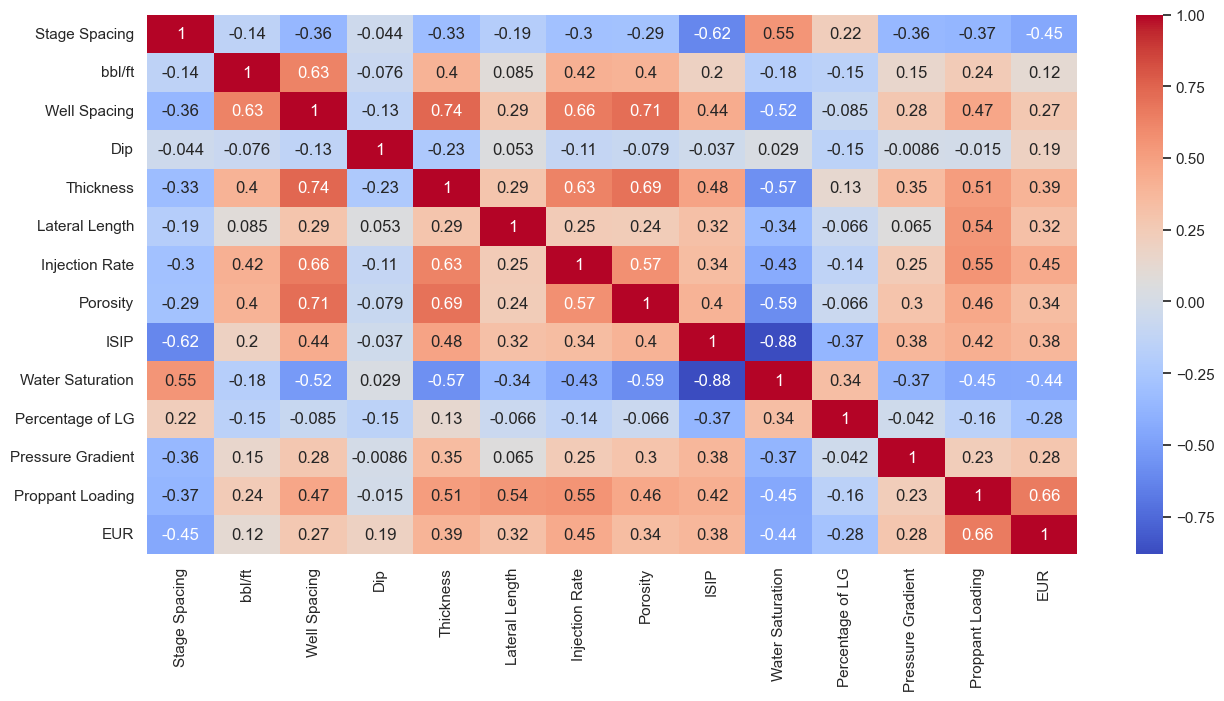

In [ ]:
train_corr_vintage = strat_train_set.loc[strat_train_set.Category == 'Vintage', :]._get_numeric_data().corr()

sns.heatmap(train_corr_vintage, annot=True, cmap='coolwarm');

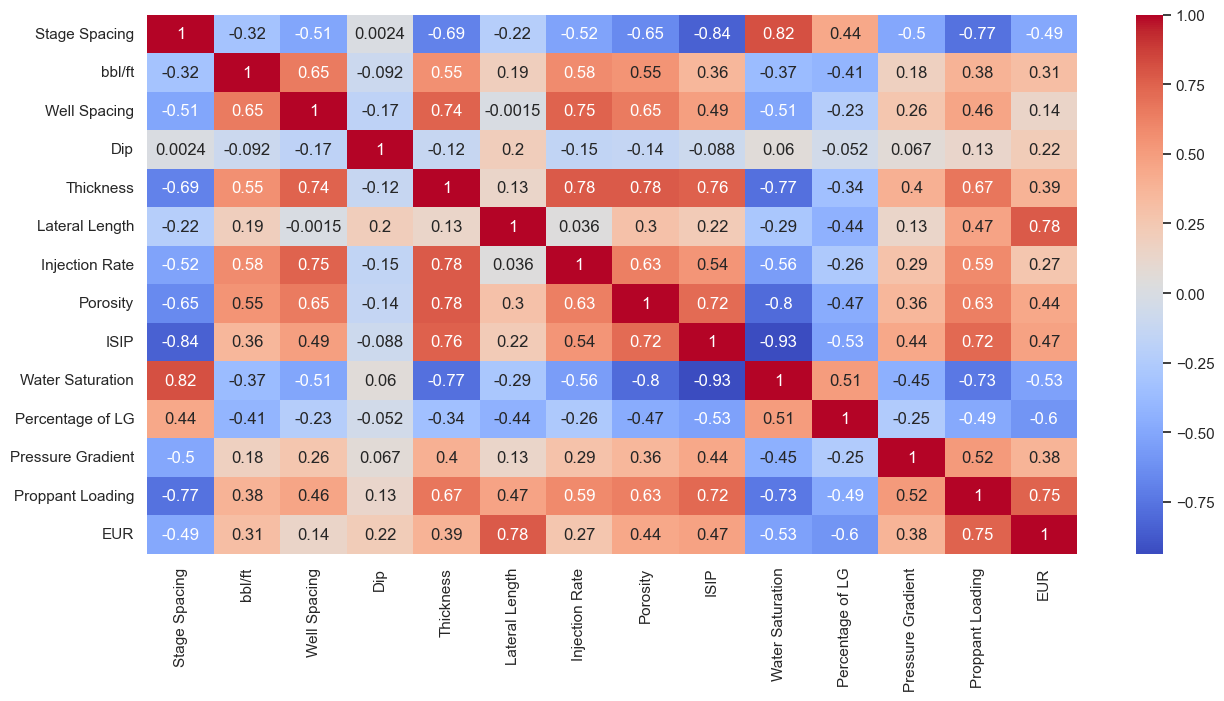

In [ ]:
train_corr_new = strat_train_set.loc[strat_train_set.Category == 'New_Design', :]._get_numeric_data().corr()

sns.heatmap(train_corr_new, annot=True, cmap='coolwarm');

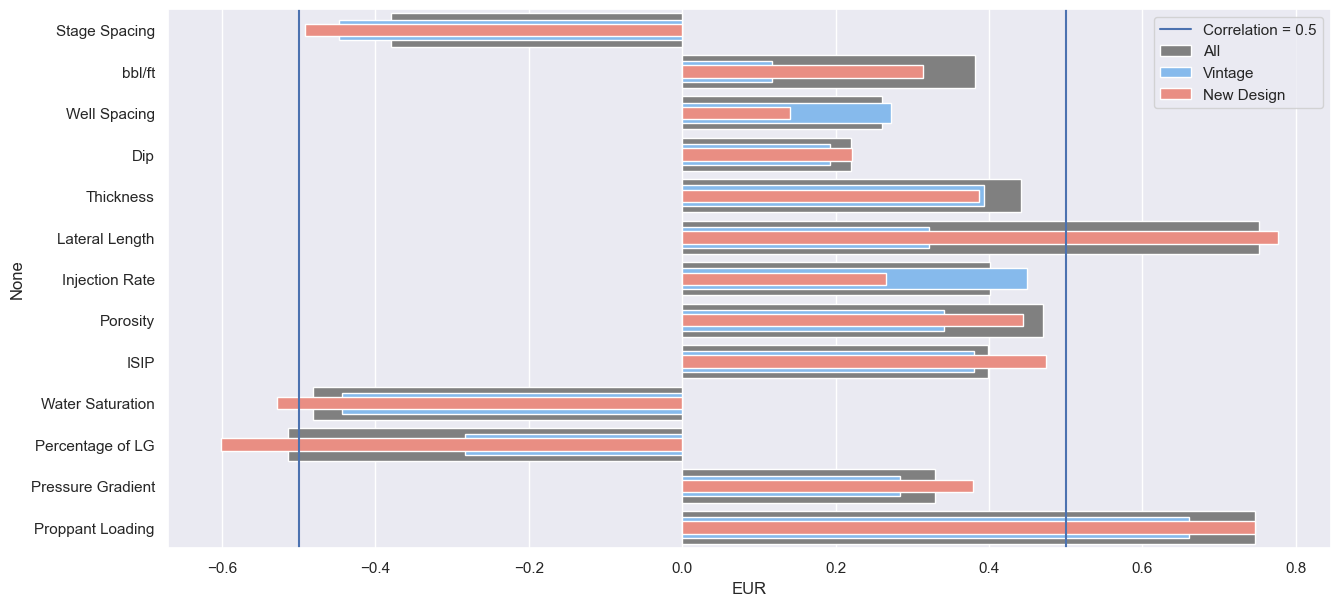

In [ ]:
sns.barplot(x=train_corr.loc['Stage Spacing':'Proppant Loading':, 'EUR'], y=train_corr.loc['Stage Spacing':'Proppant Loading':, 'EUR'].index, color='grey', label='All')
sns.barplot(x=train_corr_vintage.loc['Stage Spacing':'Proppant Loading':, 'EUR'], y=train_corr_vintage.loc['Stage Spacing':'Proppant Loading':, 'EUR'].index, width=0.5, color='xkcd:sky blue', label='Vintage')
sns.barplot(x=train_corr_new.loc['Stage Spacing':'Proppant Loading':, 'EUR'], y=train_corr_new.loc['Stage Spacing':'Proppant Loading':, 'EUR'].index, width=0.3, color='salmon', label='New Design')

plt.axvline(-0.5, label='Correlation = 0.5')
plt.axvline(0.5)
plt.legend(ncol = 1, loc = 'upper right');